In [21]:
import lightfm
from lightfm.data import Dataset
from pyspark.sql import SparkSession
import json
from itertools import islice, product
from time import time
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [2]:
username = 'zixuanshao'
#username = 'prernamishra'

In [3]:
import pyarrow.parquet as pq

train_small = pq.read_table(f'/Users/{username}/Downloads/cf_train_small.parquet').to_pandas()
test_small = pq.read_table(f'/Users/{username}/Downloads/cf_test_small.parquet').to_pandas()

train_medium = pq.read_table(f'/Users/{username}/Downloads/cf_train_medium.parquet').to_pandas()
test_medium = pq.read_table(f'/Users/{username}/Downloads/cf_test_medium.parquet').to_pandas()

In [4]:
from lightfm.cross_validation import random_train_test_split

def transform_interaction(train, test):
    
    train = train.drop(columns='__index_level_0__')
    test = test.drop(columns='__index_level_0__')
    
    train_test = train.merge(test, how='outer', on=['user_idx', 'track_idx'], suffixes=['_train','_test'])
    train_test = train_test.fillna(0)
    
    inter_train = pd.pivot_table(train_test, index='user_idx', columns='track_idx', values='count_train', dropna=False)
    inter_test = pd.pivot_table(train_test, index='user_idx', columns='track_idx', values='count_test', dropna=False)
    inter_train = inter_train.fillna(0)
    inter_test = inter_test.fillna(0)
    
    train_csr = csr_matrix(inter_train.values)
    test_csr = csr_matrix(inter_test.values)
    
    return train_csr, test_csr

In [6]:
start = time()
train_mt, test_mt = transform_interaction(train_small, test_small)
time_transform = time()-start
print(f"total transforming time {time_transform}")

total transforming time 374.982204914093


In [9]:
from lightfm import LightFM

def lightfm_train(train, rank, regParam, maxIter, model_type='warp'):
    

    if model_type == 'bpr':
        model = LightFM(loss='bpr',
                no_components=rank,
                user_alpha=regParam)
        
    else:    
        model = LightFM(loss='warp',
                no_components=rank,
                user_alpha=regParam)

    model = model.fit(train, epochs=maxIter,verbose=False)
    
    return model

In [10]:
from lightfm.evaluation import precision_at_k
from time import time

def train_and_test(train, test, rank, regParam, maxIter, top=500, model_type='warp'):

    
    st = time()
    
    model = lightfm_train(train, rank, regParam, maxIter, model_type='warp')
    p_at_k = precision_at_k(model, test, k=top).mean()
    
    t = round(time()-st, 5)
    
    print('Model with maxIter = {}, reg = {}, rank = {} complete'.format(maxIter,regParam,rank))
    print('Precision at K:', p_at_k)
    print('Time used:', t)
    
    return p_at_k, t

In [14]:
ranks = [5, 10, 20, 30, 40, 50]

In [15]:
regs = [0.01, 0.05, 0.1, 0.5]

In [36]:
# log results from Spark ALS with the same parameters
rank_precision = [0.0057, 0.0064, 0.0071, 0.0074, 0.0076, 0.0078]
rank_time = [117.56, 237.06, 97.80, 180.27, 166.46, 257.89]
reg_precision = [0.0065, 0.0064, 0.0065, 0.0062]
reg_time = [68.28, 113.76, 139.48, 112.36]

In [28]:
pk_dict = {'warp':[], 'bpr':[]}
t_dict = {'warp':[], 'bpr':[]}

In [29]:
for model in ['warp', 'bpr']:
    for rank in ranks:
        pk_1, time_1 = train_and_test(train_mt, test_mt, rank, 1, 10, top=500, model_type=model)
        pk_dict[model].append(pk_1)
        t_dict[model].append(time_1+time_transform)

Model with maxIter = 10, reg = 1, rank = 5 complete
Precision at K: 0.0052537015
Time used: 12.20736
Model with maxIter = 10, reg = 1, rank = 10 complete
Precision at K: 0.0052023693
Time used: 15.02014
Model with maxIter = 10, reg = 1, rank = 20 complete
Precision at K: 0.0052023693
Time used: 22.40973
Model with maxIter = 10, reg = 1, rank = 30 complete
Precision at K: 0.005241856
Time used: 29.2968
Model with maxIter = 10, reg = 1, rank = 40 complete
Precision at K: 0.005218164
Time used: 25.19526
Model with maxIter = 10, reg = 1, rank = 50 complete
Precision at K: 0.0052398816
Time used: 33.39308
Model with maxIter = 10, reg = 1, rank = 5 complete
Precision at K: 0.005249753
Time used: 13.21321
Model with maxIter = 10, reg = 1, rank = 10 complete
Precision at K: 0.0052398816
Time used: 15.63227
Model with maxIter = 10, reg = 1, rank = 20 complete
Precision at K: 0.0052300096
Time used: 21.98546
Model with maxIter = 10, reg = 1, rank = 30 complete
Precision at K: 0.0052142153
Time u

In [30]:
pk_dict2 = {'warp':[], 'bpr':[]}
t_dict2 = {'warp':[], 'bpr':[]}
for model in ['warp', 'bpr']:
    for reg in regs:
        pk_1, time_1 = train_and_test(train_mt, test_mt, 5, reg, 10, top=500, model_type=model)
        pk_dict2[model].append(pk_1)
        t_dict2[model].append(time_1+time_transform)

Model with maxIter = 10, reg = 0.01, rank = 5 complete
Precision at K: 0.004469891
Time used: 8.2602
Model with maxIter = 10, reg = 0.05, rank = 5 complete
Precision at K: 0.004458045
Time used: 8.54631
Model with maxIter = 10, reg = 0.1, rank = 5 complete
Precision at K: 0.00446002
Time used: 8.82011
Model with maxIter = 10, reg = 0.5, rank = 5 complete
Precision at K: 0.005245805
Time used: 9.69568
Model with maxIter = 10, reg = 0.01, rank = 5 complete
Precision at K: 0.004404738
Time used: 9.13855
Model with maxIter = 10, reg = 0.05, rank = 5 complete
Precision at K: 0.0044580456
Time used: 8.31553
Model with maxIter = 10, reg = 0.1, rank = 5 complete
Precision at K: 0.0044402764
Time used: 9.02253
Model with maxIter = 10, reg = 0.5, rank = 5 complete
Precision at K: 0.0051885485
Time used: 10.43738


In [31]:
pk_dict

{'warp': [0.0052537015,
  0.0052023693,
  0.0052023693,
  0.005241856,
  0.005218164,
  0.0052398816],
 'bpr': [0.005249753,
  0.0052398816,
  0.0052300096,
  0.0052142153,
  0.0052201385,
  0.0052142157]}

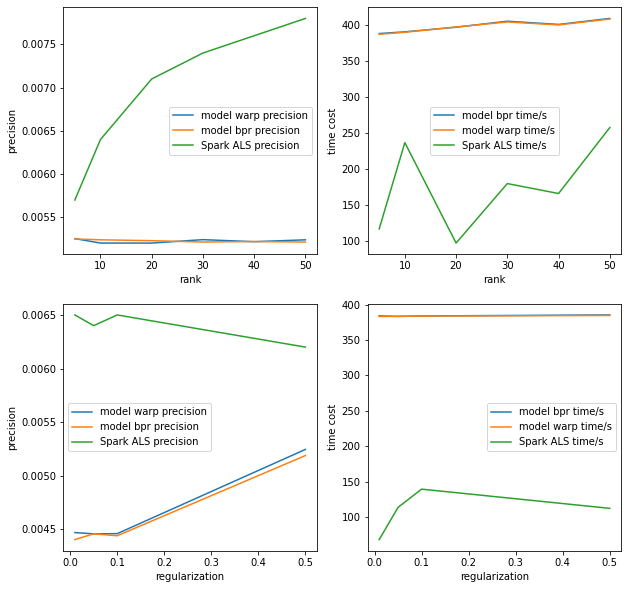

In [43]:
models = ['warp', 'bpr']
f, axs = plt.subplots(2,2, figsize=[10,10])
for i, j in product(range(2), range(2)):
    if i == 0:
        if j == 0:
            axs[i, j].plot(ranks, pk_dict[models[j]], label=f'model {models[j]} precision')
            axs[i, j].plot(ranks, pk_dict[models[j+1]], label=f'model {models[j+1]} precision')
            axs[i, j].plot(ranks, rank_precision, label='Spark ALS precision')
            axs[i, j].set_ylabel('precision')
        else:
            axs[i, j].plot(ranks, t_dict[models[j]], label=f'model {models[j]} time/s')
            axs[i, j].plot(ranks, t_dict[models[j-1]], label=f'model {models[j-1]} time/s')
            axs[i, j].plot(ranks, rank_time, label='Spark ALS time/s')
            axs[i, j].set_ylabel('time cost')
        
        axs[i, j].set_xlabel('rank')
    else:
        if j == 0:
            axs[i, j].plot(regs, pk_dict2[models[j]], label=f'model {models[j]} precision')
            axs[i, j].plot(regs, pk_dict2[models[j+1]], label=f'model {models[j+1]} precision')
            axs[i, j].plot(regs, reg_precision, label='Spark ALS precision')
            axs[i, j].set_ylabel('precision')
        else:
            axs[i, j].plot(regs, t_dict2[models[j]], label=f'model {models[j]} time/s')
            axs[i, j].plot(regs, t_dict2[models[j-1]], label=f'model {models[j-1]} time/s')
            axs[i, j].plot(regs, reg_time, label='Spark ALS time/s')
            axs[i, j].set_ylabel('time cost')
        
        axs[i, j].set_xlabel('regularization')
    axs[i,j].legend()